In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

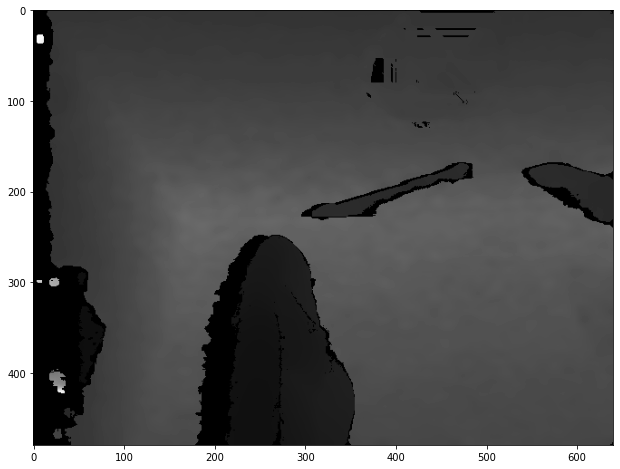

In [3]:
image_depth = cv2.imread('data/20201219_073658/depth/depth023307409300.png', cv2.IMREAD_ANYDEPTH)
# image_depth = cv2.imread('data/20201219_073658/depth/depth000023966100.png', cv2.IMREAD_ANYDEPTH)

# print(image_depth)
# print(image_depth.dtype)
plt.figure(figsize=(16, 8))
plt.imshow(image_depth, cmap='gray')

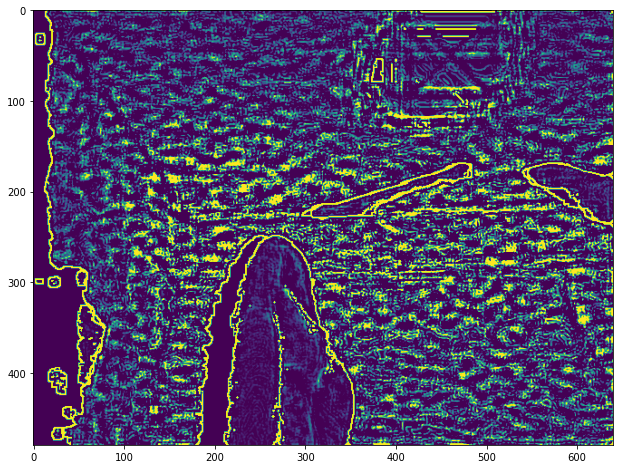

In [4]:
laplacian = cv2.Laplacian(image_depth, cv2.CV_8U, ksize=5)

plt.figure(figsize=(16, 8))
plt.imshow(laplacian)

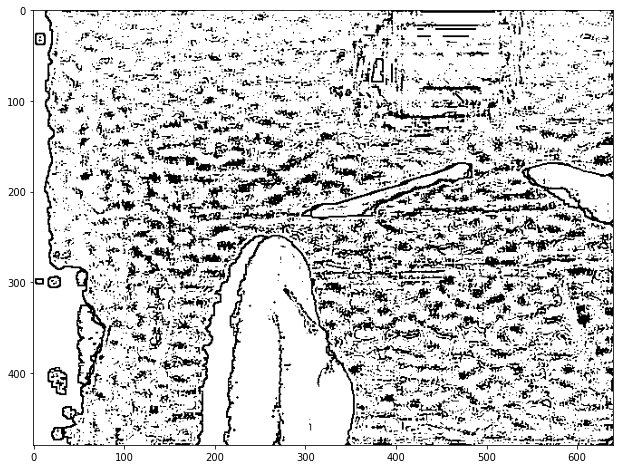

In [5]:
# tmp = cv2.convertScaleAbs(laplacian, alpha=(255/65535))
ret, line = cv2.threshold(laplacian, 0, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# kernel = np.ones((3,3), np.uint8)
# line = cv2.morphologyEx(line, cv2.MORPH_OPEN, kernel, iterations=2)
# line = cv2.dilate(line, kernel, iterations=2)
# print(line)
plt.figure(figsize=(16, 8))
plt.imshow(line, cmap='gray')

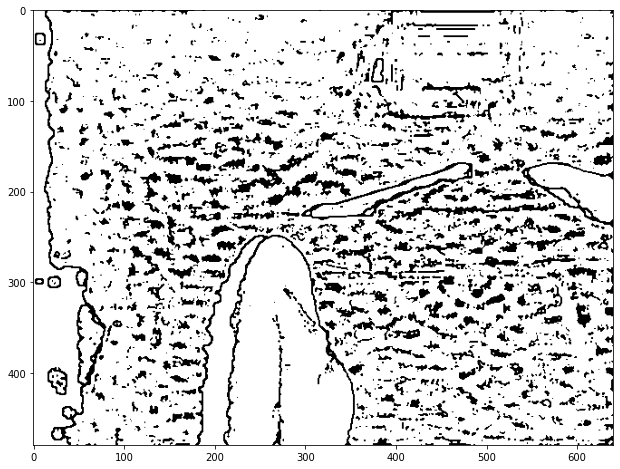

In [6]:
# tmp = cv2.convertScaleAbs(line, alpha=(255/65535))
# line = cv2.fastNlMeansDenoising(line, h=1)
line = cv2.medianBlur(line, ksize=3)

plt.figure(figsize=(16, 8))
plt.imshow(line, cmap='gray')

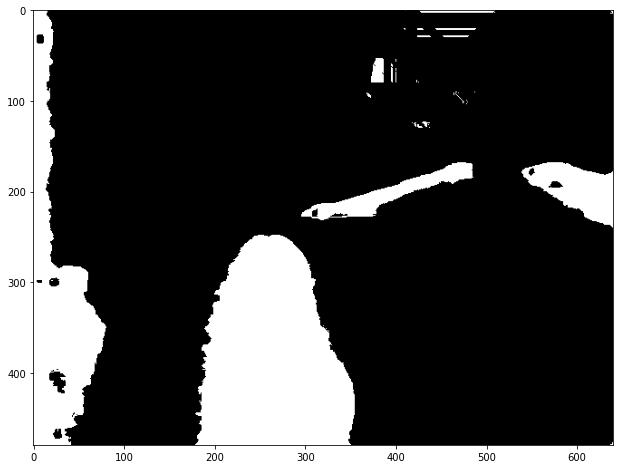

In [7]:
# 距離で二値化
ret, fg = cv2.threshold(image_depth, 0, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# print(fg)
plt.figure(figsize=(16, 8))
plt.imshow(fg, cmap='gray')

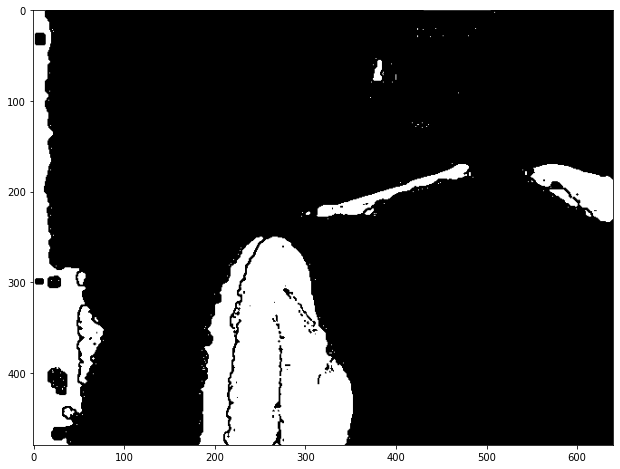

In [8]:
thresh = cv2.bitwise_or(fg, fg, mask=line)
# print(thresh)
plt.figure(figsize=(16, 8))
plt.imshow(thresh, cmap='gray')

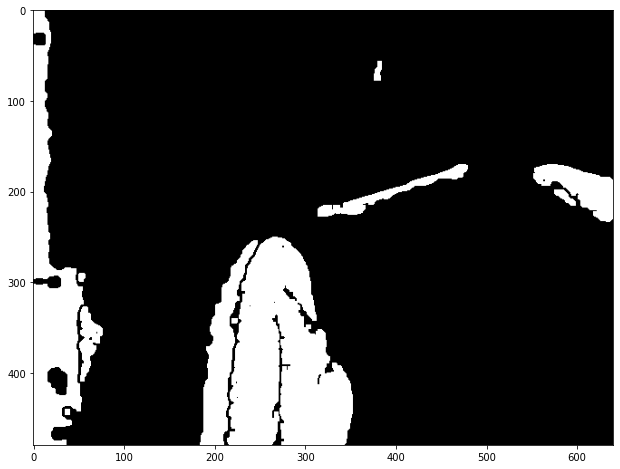

In [9]:
# noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# print(opening)
plt.figure(figsize=(16, 8))
plt.imshow(opening, cmap='gray')

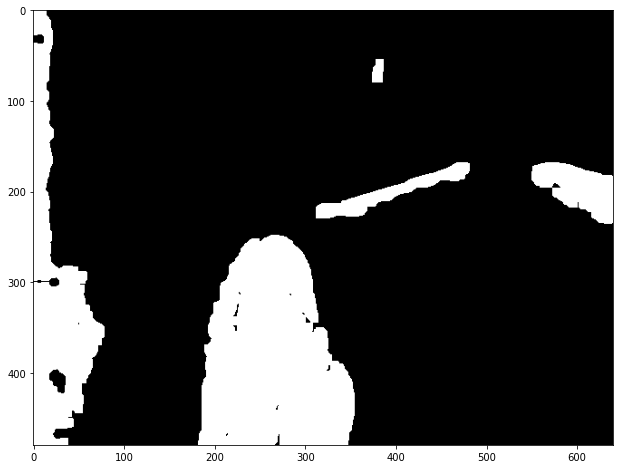

In [10]:
# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=2)

plt.figure(figsize=(16, 8))
plt.imshow(sure_bg, cmap='gray')

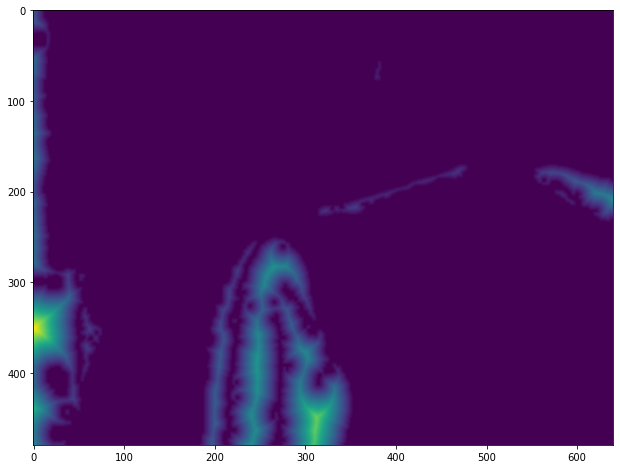

In [11]:
tmp = cv2.convertScaleAbs(opening, alpha=(255))
dist_transform = cv2.distanceTransform(tmp, cv2.DIST_L2, 5)

# print(dist_transform)
plt.figure(figsize=(16, 8))
plt.imshow(dist_transform)

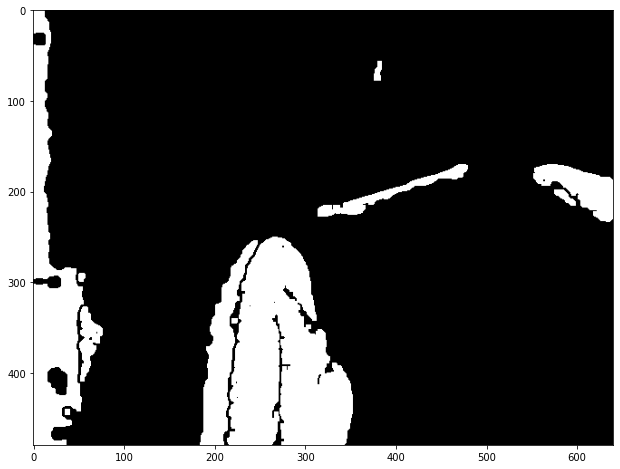

In [12]:
# Finding sure foreground area
ret, sure_fg = cv2.threshold(dist_transform, 0.005 * dist_transform.max(), 255, 0)

plt.figure(figsize=(16, 8))
plt.imshow(sure_fg, cmap='gray')

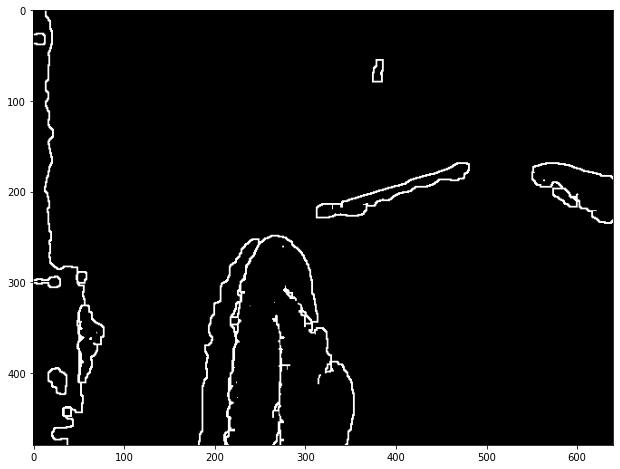

In [13]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(16, 8))
plt.imshow(unknown, cmap='gray')

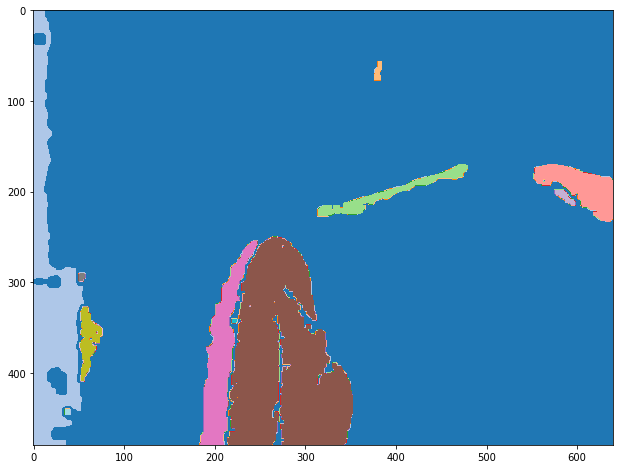

In [19]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.figure(figsize=(16, 8))
plt.imshow(markers, cmap='tab20')

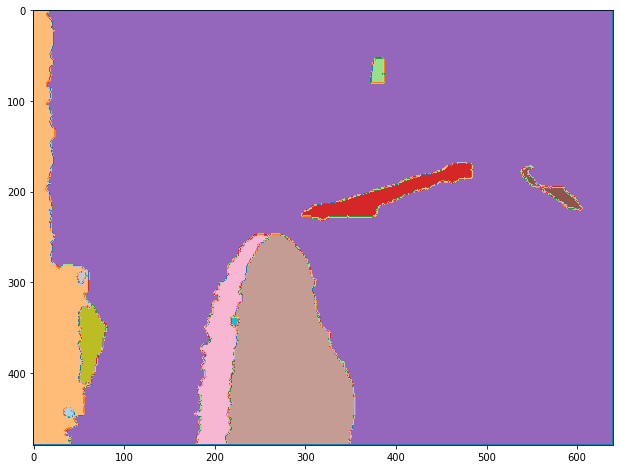

In [15]:
tmp = cv2.convertScaleAbs(image_depth, alpha=(255/65535))
color = cv2.cvtColor(tmp, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(color, markers)

plt.figure(figsize=(16, 8))
plt.imshow(markers, cmap='tab20')

In [16]:
color = cv2.cvtColor(image_depth, cv2.COLOR_GRAY2RGB)
# color[markers == -1] = [255, 0, 0]
color[markers == 1] = [255, 0, 0]
color[markers == 4] = [0, 255, 0]
color = o3d.geometry.Image(color)
color = np.array(color)

plt.imshow(color)
plt.figure(figsize=(16, 8))
cv2.imwrite('tmp.png', color)

NameError: name 'o3d' is not defined

In [579]:
import open3d as o3d

# cv2.imwrite('tmp.png', color)
color_raw = o3d.io.read_image('data/20201219_073658/color/color023307409300.png')
# color_raw = o3d.io.read_image('tmp.png')
depth_raw = o3d.io.read_image('data/20201219_073658/depth/depth023307409300.png')
depth_raw = np.array(depth_raw)
depth_raw[markers != 4] = 0
depth_raw = o3d.geometry.Image(depth_raw)
# print(depth_raw)
# rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(color), depth_raw)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)

In [580]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

o3d.visualization.draw_geometries([pcd])

In [581]:
# pcd_arrow = pcd
pcd_arrow, ind = pcd.remove_radius_outlier(nb_points=16, radius=0.05)
obb = pcd_arrow.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([pcd, obb])

In [498]:
color_raw = o3d.io.read_image('data/20201219_073658/color/color023307409300.png')
depth_raw = o3d.io.read_image('data/20201219_073658/depth/depth023307409300.png')
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)

pcd_all = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

o3d.visualization.draw_geometries([pcd_all, obb])

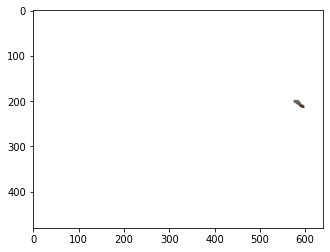

In [582]:
image_color = cv2.imread('data/20201219_073658/color/color023307409300.png')
image_color = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
image_color[markers != 6] = [255, 255, 255]
plt.imshow(image_color)